# Frequency Response Function Demo

In [2]:
import os
import sys
import math
import numpy as np
import numexpr as ne
sys.path.append('../..')
import affect.exodus as ex

Our Exodus input file, field variable names, and mesh nodes we are interested in (we use zero based nodes ID's).

In [3]:
path = './SRS-FRF-example/model/1/p1f-out.h'
input_variable = 'AForceZ'
output_variable = 'AccZ'
input_node = 1
output_node = 0

Open Exodus and read fields for all times

In [4]:
with ex.DatabaseFile(path) as e:
    times = e.globals.times()
    num_times = times.size
    names = e.nodal.variable_names()
    input_id = names.index(input_variable)
    output_id = names.index(output_variable)
    output_array = e.nodal.variable_at_times(output_id, output_node, 0, num_times)
    input_array = e.nodal.variable_at_times(input_id, input_node, 0, num_times)

Compute timestep $\Delta t$, and $\Delta f = \dfrac{1}{n_{time} \Delta t}$

In [5]:
dt = times[1] - times[0]
df = 1.0 / (float(num_times) * dt)

Get $n_{time/2} = \lfloor{\dfrac{n_{time}}{2}}\rfloor$, and $f_i = \{0,\;\Delta f,\;2\Delta f,\;3\Delta f,\;...,\; n_{time/2}\Delta f\}$

In [6]:
num_times_2 = int(math.floor(num_times / 2))
f = np.linspace(0.0, float(num_times_2)*df, num_times_2+1)

Compute the two fast fourier transforms of the fields, and the frequency response function 

In [7]:
h_output = np.fft.fft(output_array)[0:num_times_2+1] * dt
h_input = np.fft.fft(input_array)[0:num_times_2+1] * dt
frf = ne.evaluate("where(h_input != 0, real(abs(h_output / h_input)), 0.0)")

## Plot the FRF

Compute the peaks and show an interactive chart

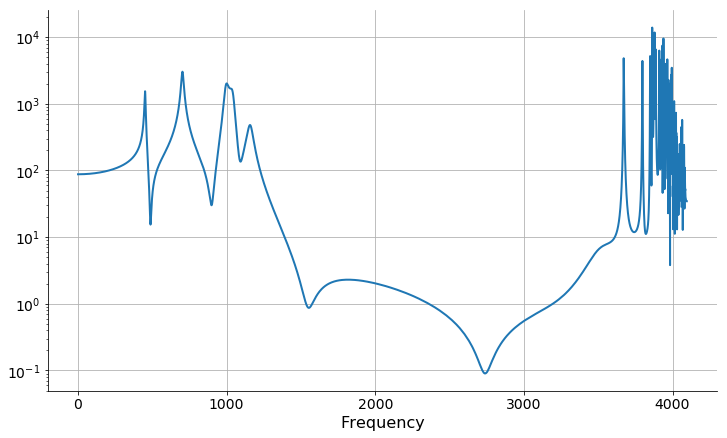

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import argrelmax
peaks = argrelmax(frf, order=2)
fig, ax = plt.subplots(figsize=(12,7))
ax.semilogy(f, frf, lw=2)
plt.grid(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Frequency", fontsize=16)
plt.show()

In [10]:
from scipy.signal import argrelmax
import plotly
import plotly.plotly
from plotly.graph_objs import Scatter, Layout, Data


plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

indices = argrelmax(frf, order=2)

line = Scatter(
    x=f,
    y=frf,
    name = 'H(ω)',
    line=dict(
            color='rgba(156, 165, 196, 1.0)',
            width=2,
        ),
)
peaks = Scatter(
    x=[f[j] for j in indices[0]],
    y=[frf[j] for j in indices[0]],
    mode='markers',
    marker=dict(
        size=6,
        color='rgba(106, 115, 146, 1.0)',
        symbol='circle'
    ),
    name='Peak'
)

data = Data([line,peaks])

layout = Layout(
    title="FRF",
    xaxis=dict(
        title='Frequency, ω',
        type='linear',
        autorange=True,
        showticklabels=True,
        ticks='outside',
        showline=True
    ),
    yaxis=dict(
        title='Response, H(ω)',
        type='log',
        exponentformat='power',
        autorange=True,
        showticklabels=True,
        autotick=False,
        ticks='outside',
        showline=True,
        ticksuffix=' ',
        showticksuffix='all'
    )
)

fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig, show_link=False)